# Custom Time Evolution

GRANAD lets you customize the Master Equation you simulate and extract any information from it.

*Note*: Please consult the tutorial on potentials first.

*Note*: While a bit more complicated, this tutorial can help you make your simulations not only more versatile, but also increase their efficiency.

*Note*: This is still rough. In the future, I might package the functions into a "Term" object or sth like that, but this will be purely cosmetic. The underlying functions won't change.

## Hamiltonian

When calling the integration for the master equation, you can give an optional argument, `hamiltonian`. As already discussed, this argument represents a Hamiltonian as a dictionary of functions.

Up to now, we just wanted to use custom potentials, so we simply added them to the dictionary. Let's look more closely at what is going on by considering a flake under CW illumination.

In [1]:
from granad import MaterialCatalog, Triangle, Wave
flake = MaterialCatalog.get( "graphene" ).cut_flake( Triangle(15)  )
wave = Wave( amplitudes = [1.0, 0., 0.], frequency = 1.0 )
hamiltonian_model = flake.get_hamiltonian(illumination = wave)
print(hamiltonian_model.keys())

dict_keys(['bare_hamiltonian', 'coulomb', 'potential'])


As discussed, the default Hamiltonian just has three terms:

1. a bare hamiltonian.
2. an induced coulomb interaction.
3. an external potential.

Each of these terms is represented by a function. Every function accepts the following three arguments:

1. time
2. the density matrix at this time
3. an argument object `args`. It contains all required "static" information, like relaxation rates, energies or operators (remember we use the Schrödinger picture, so, e.g. the dipole operator does not depend on time).

Every function maps these arguments to a complex matrix. Before running a simulation, the functions in the dictionary get turned into a list `func_list`. 

The matrix representation of the Hamiltonian is then given by applying and adding these functions, like so `H[time] = sum( f(times[time], density_matrix[time], args) for f in func_list )`.

## Argument Objects

What does the `args` object contain, exactly? We can create this object ourselves. It is just a named tuple (like a C struct) and we can inspect its contents by looking at its fields 

In [2]:
args = flake.get_args()
print(args._fields)

('hamiltonian', 'energies', 'coulomb_scaled', 'initial_density_matrix', 'stationary_density_matrix', 'eigenvectors', 'dipole_operator', 'electrons', 'relaxation_rate', 'propagator', 'spin_degeneracy', 'positions')


We can access individual entries

In [3]:
print(args.dipole_operator.shape)

(3, 46, 46)


The `args` object is a lower-level representation of our OrbitalList object: a collection of numbers and arrays that represent the structure we are simulating.

The time evolution depends on time, the density matrix and the structure we are simulating. This is directly reflected in the signature of a "term". As discussed above, a single function in the Hamiltonian
looks like `term: time, density_matrix, args -> matrix`.

## Computing Terms

Now that we know everything, we can take out and apply individual terms of the default Hamiltonian. First, let's check that the bare hamiltonian is correct

In [4]:
import jax.numpy as jnp
h_bare = hamiltonian_model["bare_hamiltonian"]
time = 0.0
jnp.all(flake.hamiltonian == h_bare( time, args.initial_density_matrix, args ))

Array(True, dtype=bool)

The function just returns the bare hamiltonian, independent of the time and density matrix. Let's compute the coulomb potential at the initial time

In [5]:
coulomb = hamiltonian_model["coulomb"]
coulomb_matrix = coulomb( time, args.initial_density_matrix, args ) 
jnp.all( coulomb_matrix == 0.0 )

Array(True, dtype=bool)

Right at the beginning, there is no induced coulomb potential (all entries in the matrix are zero), because the system is initially in its ground state. Last, there is the external potential. Since we do not have transition dipole moments, it will be entirely diagonal

In [6]:
potential = hamiltonian_model["potential"]
potential_matrix = potential( time, args.initial_density_matrix, args )
jnp.all( potential_matrix == jnp.diag(potential_matrix.diagonal()) )

Array(True, dtype=bool)

## Modelling Terms

Now we know how to inject arbitrary terms in the time evolution. We must define a function that

1. Accepts `time, density_matrix, args`
2. Returns a NxN complex matrix
3. Additionally, the function must be JAX-JIT compatible. In essence, use only Python and jax.numpy operations.

Then we just insert it in the dictionary, potentially overwriting a default key (remember the keys don't matter, you can add as many functions as you want and name them however you want).

Let's illustrate this at the example of a custom scalar potential. We want to replace the dipole-gauge coupling $E P$ with a scalar potential representing a plane-wave pulse. Let's define this potential first

In [7]:
amplitudes = jnp.array([1e-5, 0, 0])
omega = 2*jnp.pi
sigma = 1
t0 = 4
def pulsed_potential( time, density_matrix, args ):
    field = (amplitudes * jnp.cos(omega * time) * jnp.exp( -(time-t0)**2 / sigma**2 ) )
    diagonal_part = args.positions @ field
    return jnp.diag( diagonal_part )

Now, we replace the default potential with our custom term, just as we did before in the case of the pulsed dipole.

In [8]:
hamiltonian_model["potential"] = pulsed_potential

To run a time-domain simulation, we just pass the modified hamiltonian dictionary directly, as demonstrated in the first section

RHS compiled
RHS compiled


100.0 %


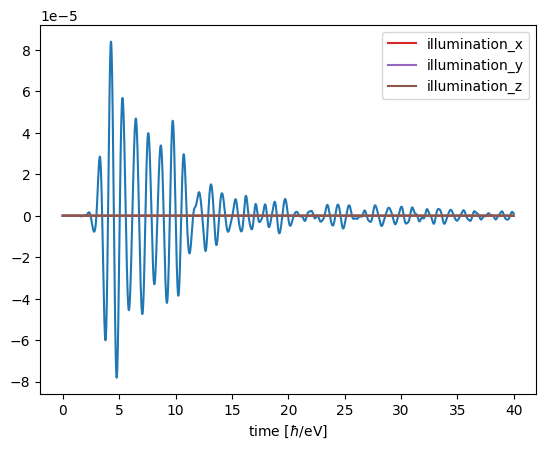

In [9]:
result = flake.master_equation( hamiltonian = hamiltonian_model, expectation_values = [flake.dipole_operator], relaxation_rate = 1/10, end_time = 40)
flake.show_res( result )

That's it.

## Custom Argument Objects

TBD

## Modelling Dissipators

Dissipators work exactly like the Hamiltonian.

1. Define a function `diss : time, density_matrix, args -> jax.Array`
2. put it in a dictionary `dissipator_model["diss"] = diss`
3. Pass `dissipator = dissipator_model` to the integrator function. 

You can also get defaults

In [10]:
dissipator_model = flake.get_dissipator(relaxation_rate = 1/10)
print( dissipator_model )

{'decoherence_time': <function DecoherenceTime.<locals>.<lambda> at 0x7f45e7f48720>}


NOTE: just passing this default to the master equation won't work. You have to specify the relaxation rate again. This will likely change in the future, but ows to the separation of computation and data GRANAD tries to adhere to.

## Postprocesses

You can define custom postprocesses. These are functions with the signature `postprocess : density_matrix_batch, args -> array`. The `density_matrix_batch` is an array of shape `TxNxN`, where `T` encodes time.

For example, if you are only interested in the occupation of the 0-th state

In [11]:
def extract_element(density_matrices, args):
    return density_matrices[:,0,0]

In [12]:
result = flake.master_equation( postprocesses = {"element" : extract_element},  relaxation_rate = 1/10, end_time = 40 )
print(result.output[0].shape)

RHS compiled
RHS compiled


100.0 %
(4000,)
